<a href="https://colab.research.google.com/github/trankha1655/CS114_ML/blob/main/Colab_Research/Bai_Tap_Colab_So_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÀI TẬP COLAB SỐ 03 - Dự đoán điểm thi cuối kì môn IT001
**Lớp CS114.L21**

Nhóm:


1.   Trần Phan Nhật Kha - 19521655
2.   Trần Gia Nghĩa - 19521901
3.   Võ Tá Lâm - 1952174419521744



# IMPORT AND DISCOVERY DATA

Kết nối với google drivedrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Import các thư viện cần thiết cho quá trình đánh giá và tiền xử lý dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Đọc dữ liệu từ đường dẫn đến thư mục chứa dữ liệu trong google drive

In [ ]:
data_wecode = pd.read_csv('/content/gdrive/MyDrive/NMLT/wecode.csv')
data_score = pd.read_csv('/content/gdrive/MyDrive/NMLT/score_training.csv')

In [ ]:
data_wecode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264606 entries, 0 to 264605
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             264606 non-null  int64 
 1   assignment_id  264606 non-null  int64 
 2   problem_id     264606 non-null  int64 
 3   user_id        264606 non-null  int64 
 4   is_final       264606 non-null  int64 
 5   status         264605 non-null  object
 6   pre_score      264606 non-null  int64 
 7   coefficient    264606 non-null  object
 8   file_name      264606 non-null  object
 9   language_id    264606 non-null  int64 
 10  created_at     264606 non-null  object
 11  updated_at     264606 non-null  object
dtypes: int64(7), object(5)
memory usage: 24.2+ MB


In [ ]:
data_wecode.head(10)

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07
5,9,0,5,4,0,Compilation Error,0,100,solution-5,2,2020-10-30 11:16:57,2020-10-30 11:16:58
6,10,0,6,4,1,SCORE,10000,100,solution-6,2,2020-10-30 11:18:47,2020-10-30 11:18:55
7,11,0,7,4,1,SCORE,10000,100,solution-7,2,2020-10-30 11:20:07,2020-10-30 11:20:15
8,12,0,8,4,1,SCORE,10000,100,solution-8,2,2020-10-30 11:21:02,2020-10-30 11:21:10
9,13,0,9,4,1,SCORE,10000,100,solution-9,2,2020-10-30 11:21:36,2020-10-30 11:21:44


In [ ]:
data_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      975 non-null    int64 
 1   QT      973 non-null    object
 2   GK      974 non-null    object
 3   TH      974 non-null    object
 4   CK      974 non-null    object
 5   TBM     974 non-null    object
 6   TBTL    974 non-null    object
dtypes: int64(1), object(6)
memory usage: 53.4+ KB


In [ ]:
data_score.head()

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10,9,8.5,8.5,8.8,8.52
1,24,10,8,10,9.5,9.4,8.41
2,27,10,10,10,10,10,8.67
3,28,10,9.5,7.5,9.5,9.2,7.39
4,29,10,9.5,5,8.5,8.2,8.05


# PRE-PROCESSING AND VISUALIZE DATA

# PRE-PROCESSING DATA

Xét các trường hợp sau để đánh giá mối tương quan với điểm thi cuối kì:
1. Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit
2. Tổng số problem đã sumbit / Tổng số submissions 
3. Số lần submit đúng (pre_score=10000) / tổng số submissions 
4. Tổng pre_score của các submssion có is_final = 1 
5. Tổng của max pre_score của mỗi problem_id và tổng số submission

Trường hợp 1: Tổng số problem đã solved (is_final = 1 && pre_score=10000) / Tổng số problem có submit

In [ ]:
#Lấy các cột sử dụng cho bài toán
visualize_data = data_wecode[['user_id', 'assignment_id', 'problem_id', 'is_final', 'status', 'pre_score', 'coefficient']]

#Tổng số problem đã solved(is_final = 1 và pre_score = 100000)
case_1 = visualize_data[(visualize_data['is_final'] == 1) & (visualize_data['pre_score'] == 10000)].groupby(by = 'user_id').sum()
case_1 = case_1.drop(['pre_score','problem_id','assignment_id'],axis = 1) #Bỏ các cột không cần thiết

#Tổng số problem đã submitted
total_problem_submitted = visualize_data[['user_id','assignment_id','problem_id']].drop_duplicates() 
total_problem_submitted = total_problem_submitted[['user_id', 'problem_id']].groupby('user_id', as_index = False).count()

case_1 = case_1.merge(total_problem_submitted,on='user_id',how = 'right').fillna(0) #Kết phải để lấy cả trường hợp sinh viên không có problem nào solved
case_1['prob_solved/prob_tried'] = case_1['is_final']/case_1['problem_id']
case_1.rename(columns={'is_final':'prob_solved','problem_id':'prob_tried'},inplace = True)
case_1.set_index('user_id',inplace = True)

In [ ]:
case_1

,prob_solved,prob_tried,prob_solved/prob_tried
user_id,,,
1,1.0,2,0.500000
4,37.0,41,0.902439
5,3.0,5,0.600000
6,85.0,89,0.955056
7,0.0,2,0.000000
...,...,...,...
1860,28.0,48,0.583333
1862,4.0,6,0.666667
1864,28.0,63,0.444444


Trường hợp 2: Tổng số problem đã sumbit / Tổng số submissions

In [ ]:
#Tổng số problem đã submit
case_2 = visualize_data[['user_id', 'assignment_id', 'problem_id']].drop_duplicates()
case_2 = case_2[['user_id', 'problem_id']].groupby('user_id', as_index = False).count()

#Tổng số subbmissions
total_problem_submissions = data_wecode[['user_id', 'id']].groupby('user_id', as_index = False).count()

case_2 = case_2.merge(total_problem_submissions,on = 'user_id')
case_2['problem_submitted_rate'] = case_2['problem_id']/case_2['id']
case_2.rename(columns={'problem_id':'total_submissions','id':'total_submitted'},inplace = True)

In [ ]:
case_2

,user_id,total_submissions,total_submitted,problem_submitted_rate
0,1,2,2,1.000000
1,4,41,54,0.759259
2,5,5,6,0.833333
3,6,89,130,0.684615
4,7,2,5,0.400000
...,...,...,...,...
1154,1860,48,76,0.631579
1155,1862,6,12,0.500000
1156,1864,63,187,0.336898
1157,1865,17,99,0.171717


Trường hợp 3: Số lần submit đúng (pre_score=10000) / tổng số submissions

In [ ]:
#Tổng số submissionsubmission
case_3 = visualize_data[['user_id']]
case_3 = case_3['user_id'].value_counts().sort_index()

#Số lần submit đúng
accepted_submit = visualize_data[visualize_data['pre_score']==10000].groupby(by = 'user_id').count()

case_3 = pd.concat([case_3,accepted_submit],keys = 'user_id',axis = 1)
case_3.columns = case_3.columns.droplevel()
case_3 = case_3.reset_index()
case_3.rename(columns={'user_id':'total_submissions','index':'user_id','pre_score':'total_accepted'},inplace = True)
case_3 = case_3.drop(['assignment_id','problem_id','is_final','status','coefficient'],axis = 1).fillna(0)
case_3['accepted/submissions'] = case_3['total_accepted']/case_3['total_submissions']
case_3 = case_3.set_index('user_id')

In [ ]:
case_3

,total_submissions,total_accepted,accepted/submissions
user_id,,,
1,2,1.0,0.500000
4,54,44.0,0.814815
5,6,3.0,0.500000
6,130,89.0,0.684615
7,5,0.0,0.000000
...,...,...,...
1860,76,29.0,0.381579
1862,12,4.0,0.333333
1864,187,30.0,0.160428


Trường hợp 4: Tổng pre_score của các submssion có is_final = 1

In [ ]:
case_4 = visualize_data[(visualize_data['is_final'] == 1)].groupby(by = 'user_id').sum()
case_4 = case_4.drop(['assignment_id','problem_id','is_final'],axis = 1)
case_4.rename(columns={'pre_score' : 'total_score'},inplace = True)

In [ ]:
case_4

,total_score
user_id,
1,10000
4,370000
5,30000
6,850000
7,9209
...,...
1860,329665
1862,40000
1864,439741


Trường hợp 5: Tổng của max pre_score của mỗi problem_id và tổng số submission



In [ ]:
case_5 = visualize_data[['user_id','problem_id','pre_score']]
case_5 = case_5.groupby(['user_id', 'problem_id'], as_index=False).max()
case_5 = case_5[['user_id','pre_score']].groupby('user_id', as_index=False).sum()
case_5.rename(columns={"pre_score":"total_max_score_per_problem"}, inplace=True)

In [ ]:
case_5

,user_id,total_max_score_per_problem
0,1,10000
1,4,400000
2,5,30000
3,6,850000
4,7,9209
...,...,...
1154,1860,300221
1155,1862,40000
1156,1864,439741
1157,1865,116428


In [ ]:
visualize_score = data_score[['id','CK']]
visualize_score = visualize_score.replace(r'^\s*$', np.nan, regex=True) #Chuyển các ô trống sang NaN
visualize_score = visualize_score.dropna()
visualize_score.rename(columns={'id':'user_id'},inplace = True)
visualize_score.set_index('user_id',inplace= True)
visualize_score['CK'] = visualize_score['CK'].astype(float)

In [ ]:
visualize_score

,CK
user_id,
22,8.5
24,9.5
27,10.0
28,9.5
29,8.5
...,...
1857,4.0
1859,1.5
1862,7.5


In [ ]:
summery = case_1.merge(case_2,on = 'user_id')
summery = summery.merge(case_3,on = 'user_id')
summery = summery.merge(case_4,on = 'user_id',how = 'left').fillna(0)
summery = summery.merge(case_5,on = 'user_id')
summery.drop(['prob_solved','prob_tried','total_submissions_x','total_submitted','total_submissions_y','total_accepted'],axis = 1, inplace = True)

In [ ]:
summery

,user_id,prob_solved/prob_tried,problem_submitted_rate,accepted/submissions,total_score,total_max_score_per_problem
0,1,0.500000,1.000000,0.500000,10000.0,10000
1,4,0.902439,0.759259,0.814815,370000.0,400000
2,5,0.600000,0.833333,0.500000,30000.0,30000
3,6,0.955056,0.684615,0.684615,850000.0,850000
4,7,0.000000,0.400000,0.000000,9209.0,9209
...,...,...,...,...,...,...
1154,1860,0.583333,0.631579,0.381579,329665.0,300221
1155,1862,0.666667,0.500000,0.333333,40000.0,40000
1156,1864,0.444444,0.336898,0.160428,439741.0,439741
1157,1865,0.588235,0.171717,0.101010,116428.0,116428


In [ ]:
visualize = summery.merge(visualize_score,on = 'user_id')
visualize

,user_id,prob_solved/prob_tried,problem_submitted_rate,accepted/submissions,total_score,total_max_score_per_problem,CK
0,24,0.923077,0.475610,0.487805,750299.0,760299,9.5
1,27,0.600000,0.384615,0.307692,39000.0,39000,10.0
2,29,0.900000,0.402010,0.376884,762760.0,762760,8.5
3,34,0.964286,0.385321,0.371560,822888.0,822888,6.5
4,35,0.953947,0.511785,0.511785,1477000.0,1437000,4.5
...,...,...,...,...,...,...,...
801,1856,0.741935,0.484375,0.359375,270790.0,270790,7.5
802,1857,0.925000,0.727273,0.672727,386000.0,337000,4.0
803,1859,0.100000,0.967742,0.096774,39000.0,39000,1.5
804,1862,0.666667,0.500000,0.333333,40000.0,40000,7.5


# VISUALIZE DATA

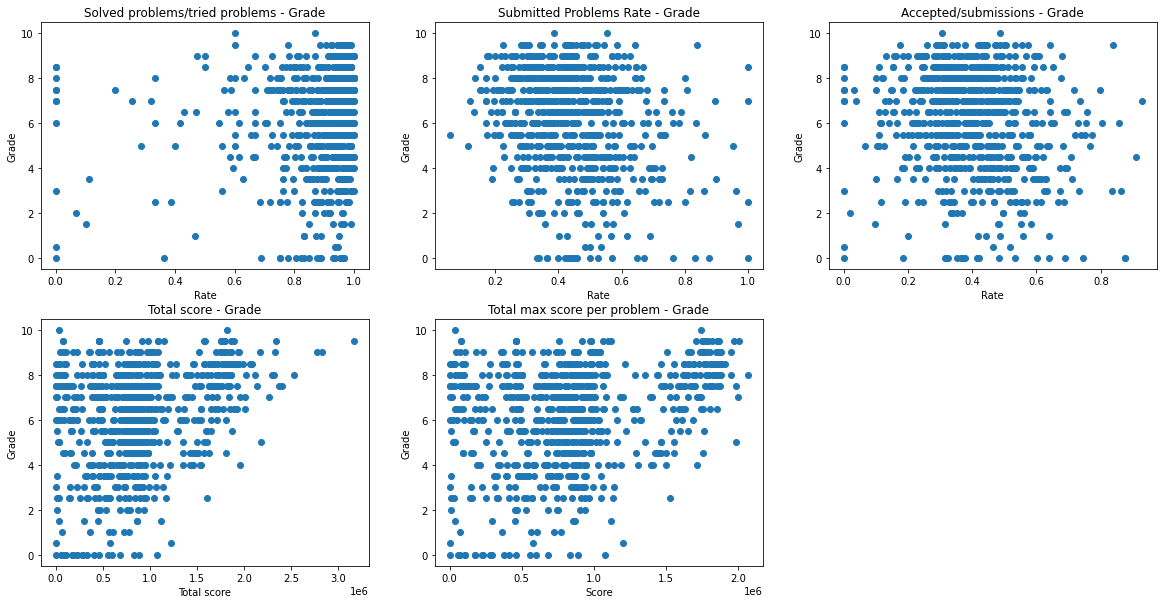

In [ ]:
fig, ((axs1, axs2, axs3), (axs4, axs5, axs6), ) = plt.subplots(2,3, figsize = (20,10))

axs1.scatter(x = visualize['prob_solved/prob_tried'],y = visualize['CK'])
axs1.set_title("Solved problems/tried problems - Grade")
axs1.set(xlabel='Rate', ylabel= 'Grade')

axs2.scatter(x = visualize['problem_submitted_rate'],y = visualize['CK'])
axs2.set_title("Submitted Problems Rate - Grade")
axs2.set(xlabel = 'Rate', ylabel = 'Grade')

axs3.scatter(x = visualize['accepted/submissions'], y = visualize['CK'])
axs3.set_title("Accepted/submissions - Grade")
axs3.set(xlabel = 'Rate', ylabel = 'Grade')

axs4.scatter(x = visualize['total_score'], y = visualize['CK'])
axs4.set_title("Total score - Grade")
axs4.set(xlabel = 'Total score', ylabel = 'Grade')

axs5.scatter(x = visualize['total_max_score_per_problem'], y = visualize['CK'])
axs5.set_title("Total max score per problem - Grade")
axs5.set(xlabel = 'Score', ylabel = 'Grade')

fig.delaxes(axs6)
plt.show()

# TRAINING AND EVALUATING MODEL


Import các thư viện cần thiết

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
column_title_train = ['prob_solved/prob_tried','problem_submitted_rate','accepted/submissions','total_score','total_max_score_per_problem']

x = np.array(visualize[column_title_train])
y = np.array(visualize[['CK']])

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state = 20)

model = LinearRegression()
model.fit(x_train,y_train)

y_pre = model.predict(x_test)
y_pre = np.round((y_pre*2))/2 #Làm tròn điểm 
mse = mean_squared_error(y_test, y_pre) #Tính Mean Square Error
print('MSE =',mse)

MSE = 4.386363636363637


# NHẬN XÉT



Sau khi train theo mô hình Linear Regression và MSE ra khá cao -> Mô hình hiện tại vẫn chưa tốt.
#   Nguyên nhân:


Chủ quan:


> * Do quá trình xử lý dữ liệu chưa tốt


> * Do chưa đánh giá tốt các tham số quan trọng cho bài toán




Khách quan: Điểm thi cuối kỳ phụ thuộc vào nhiều yếu tố hơn là kết quả thực hành wecode vì những lý do sau:

> * Kết quả wecode không chắc chắn phản ánh đúng khả năng của sinh viên vì: các bạn có thể chép code của người khác, có khả năng lập trình tốt nhưng lười làm bài tập,...
> * Tâm lý phòng thi khác hẳn với khi ở nhà làm thực hành
> * Kiến thức thi cuối kỳ có nhiều kiến thức về lý thuyết hơn so với bài tập wecode
> *v.v




